In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # this increases width to full screen

In [2]:
import numpy as np # import numerical python
import matplotlib.pyplot as plt # import plotting functions
import seaborn as sns # import nicer plotting functions
import pandas as pd # import pandas to import data
import tifffile as tiff
from tifffile import imwrite, imread

In [3]:
from CommonFunctions import Gaussians, Mask_Gen, Image_Gen
Gau_gen = Gaussians.GaussFuncs()
IG = Image_Gen.ImageGenFuncs()
MG = Mask_Gen.MaskFuncs()

In [4]:
IG.gen_camera_images

<function CommonFunctions.Image_Gen.ImageGenFuncs.gen_camera_images(gain_value, wavelength, R, G, B, dyes, n_photons, laser_int, object_locs, object_sigma=30, background_photons=100, image_h=1280, image_w=1024)>

In [5]:
from Camera_QE import getpixelefficiency
gpe = getpixelefficiency.GPE()
R, G, B, wavelength = gpe.getpixelefficiency('Camera_QE/CS505CU_QE.csv')

In [6]:
object_locs = MG.object_loc_generation()

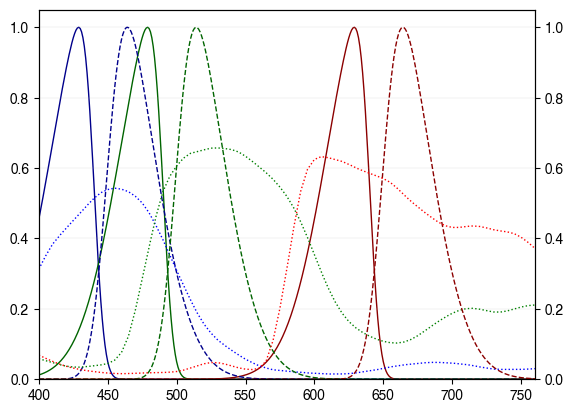

In [7]:
# let's make a few (arbitrary) dyes
# make some dyes at different colours
dye_width = 30 # 30 nm peak width
dye_abs_skew = -5 # absorption spectral skew
dye_em_skew = 3 # emission spectral skew
Abs_450 = Gau_gen.SkewGaussian_wavelength(dye_width, dye_abs_skew, 440, wavelength); Em_450 = Gau_gen.SkewGaussian_wavelength(dye_width, dye_em_skew, 450, wavelength)
Abs_500 = Gau_gen.SkewGaussian_wavelength(dye_width, dye_abs_skew, 490, wavelength); Em_500 = Gau_gen.SkewGaussian_wavelength(dye_width, dye_em_skew, 500, wavelength)
Abs_647 = Gau_gen.SkewGaussian_wavelength(dye_width, dye_abs_skew, 640, wavelength); Em_647 = Gau_gen.SkewGaussian_wavelength(dye_width, dye_em_skew, 650, wavelength)

#visualise them, and our pixel efficiencies
fig, ax = plt.subplots(1, 1)
ax2 = ax.twinx()
ax.plot(wavelength, Abs_450, lw=1, color='darkblue'); plt.plot(wavelength, Em_450, lw=1, color='darkblue', ls='--'); ax2.plot(wavelength, B, color='blue', lw=1, ls=':')
ax.plot(wavelength, Abs_500, lw=1, color='darkgreen'); plt.plot(wavelength, Em_500, lw=1, color='darkgreen', ls='--'); ax2.plot(wavelength, G, color='green', lw=1, ls=':')
ax.plot(wavelength, Abs_647, lw=1, color='darkred'); plt.plot(wavelength, Em_647, lw=1, color='darkred', ls='--'); ax2.plot(wavelength, R, color='red', lw=1, ls=':')

plt.xlim([400, 760])
ax2.set_ylim([0, 1.05])
ax.set_ylim([0, 1.05])
plt.grid(alpha=0.5, lw=0.25)
plt.show(block=False) # plot all the absorptions and emissions we have

In [8]:
# put dyes into array
dyes = np.dstack([[Abs_450, Em_450], [Abs_500, Em_500], [Abs_647, Em_647]])

# describe our laser wavelengths
lasers = np.array([420, 488, 640])

# describe our laser intensities
intensity_1 = np.array([0.1, 0.1, 1])
laser_int = np.vstack([lasers, intensity_1])

In [9]:
# get raw images, demosaiced images, and gain map
gain_value = 2 # gain value
n_photons = np.array([1e6, 1e6, 1e6]) # number of photons per dye

raw_images, colour_image_demosaic, gain_map = IG.gen_camera_images(gain_value, wavelength,
                            R, G, B, dyes, n_photons, laser_int, object_locs, object_sigma=30,
                            background_photons=100, image_h=1280, image_w=1024)

TypeError: MaskFuncs.mask_generation() takes from 1 to 6 positional arguments but 7 were given

In [ ]:
# why don't we plot all of these images
fig = plt.figure()

ax1 = plt.subplot2grid(shape=(3, 2), loc=(0, 0), colspan=1)
ax2 = plt.subplot2grid(shape=(3, 2), loc=(1, 0), colspan=1)
ax3 = plt.subplot2grid(shape=(3, 2), loc=(2, 0), colspan=1)
ax4 = plt.subplot2grid((3, 2), (0, 1), rowspan=3)

ax1.imshow(raw_images[:, :, 0], vmin=50, vmax=6000) # let's plot the red channel
ax1.set_xticklabels([]); ax1.set_yticklabels([])

ax2.imshow(raw_images[:, :, 1], vmin=50, vmax=6000) # let's plot the green channel
ax2.set_xticklabels([]); ax2.set_yticklabels([])

ax3.imshow(raw_images[:, :, 2], vmin=50) # let's plot the blue channel
ax3.set_xticklabels([]); ax3.set_yticklabels([])

ax4.imshow(colour_image_demosaic)
ax4.set_xticklabels([]); ax4.set_yticklabels([])
        
plt.tight_layout()
plt.show(block=False)